In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [2]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=4 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

In [3]:
for directory_path in glob.glob("original_images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

In [4]:
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [5]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("masked_images/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

In [6]:
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
train_images[0].shape

(256, 256, 3)

In [8]:
train_masks[0].shape

(256, 256)

In [9]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/home/ankit/Desktop/ml/Tensorflow_ENV/tfenv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [10]:
np.unique(train_masks)

array([  0,  38,  75, 113], dtype=uint8)

In [11]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [12]:
train_masks_input.shape

(25, 256, 256, 1)

In [13]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3]


In [14]:

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [15]:
######################################################
#Reused parameters in all models

n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]



In [ ]:
#######################################################################
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)


In [ ]:
# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

In [ ]:
#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

In [ ]:
model1.save('res34_backbone_50epochs.hdf5')
############################################################

In [16]:
###Model 2

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


2024-07-25 11:34:49.202714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 11:34:49.212643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 11:34:49.212960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 11:34:49.213810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


In [18]:
print(model2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

                                                                                                  
 decoder_stage1b_conv (Conv2D)  (None, None, None,   147456      ['decoder_stage1a_relu[0][0]']   
                                128)                                                              
                                                                                                  
 decoder_stage1b_bn (BatchNorma  (None, None, None,   512        ['decoder_stage1b_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 decoder_stage1b_relu (Activati  (None, None, None,   0          ['decoder_stage1b_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 decoder_s

                                                                                                  
 softmax (Activation)           (None, None, None,   0           ['final_conv[0][0]']             
                                4)                                                                
                                                                                                  
Total params: 29,933,540
Trainable params: 29,897,124
Non-trainable params: 36,416
__________________________________________________________________________________________________
None


In [20]:
history2=model2.fit(X_train2, 
          y_train_cat,
          batch_size=4, 
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))

Epoch 1/50
3/3 [==============================] - 31s 8s/step - loss: 1.0055 - iou_score: 0.0439 - f1-score: 0.0826 - val_loss: 1.0539 - val_iou_score: 0.0032 - val_f1-score: 0.0063
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.9865 - iou_score: 0.0843 - f1-score: 0.1525 - val_loss: 1.0651 - val_iou_score: 0.0046 - val_f1-score: 0.0092
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.9722 - iou_score: 0.1271 - f1-score: 0.2181 - val_loss: 1.0821 - val_iou_score: 0.0064 - val_f1-score: 0.0126
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.9634 - iou_score: 0.1651 - f1-score: 0.2727 - val_loss: 1.0804 - val_iou_score: 0.0091 - val_f1-score: 0.0177
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.9515 - iou_score: 0.2273 - f1-score: 0.3500 - val_loss: 1.0821 - val_iou_score: 0.0122 - val_f1-score: 0.0235
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.9421 - iou_score: 0.281

3/3 [==============================] - 5s 2s/step - loss: 0.8266 - iou_score: 0.8905 - f1-score: 0.9402 - val_loss: 0.8911 - val_iou_score: 0.5340 - val_f1-score: 0.6271
Epoch 47/50
3/3 [==============================] - 5s 2s/step - loss: 0.8262 - iou_score: 0.8916 - f1-score: 0.9409 - val_loss: 0.8897 - val_iou_score: 0.5368 - val_f1-score: 0.6298
Epoch 48/50
3/3 [==============================] - 5s 2s/step - loss: 0.8238 - iou_score: 0.9055 - f1-score: 0.9490 - val_loss: 0.8882 - val_iou_score: 0.5401 - val_f1-score: 0.6326
Epoch 49/50
3/3 [==============================] - 5s 2s/step - loss: 0.8261 - iou_score: 0.8898 - f1-score: 0.9398 - val_loss: 0.8877 - val_iou_score: 0.5411 - val_f1-score: 0.6336
Epoch 50/50
3/3 [==============================] - 5s 2s/step - loss: 0.8208 - iou_score: 0.9108 - f1-score: 0.9519 - val_loss: 0.8877 - val_iou_score: 0.5399 - val_f1-score: 0.6329


In [21]:
model2.save('inceptionv3_backbone_50epochs.hdf5')

#####################################################

In [16]:
###Model 3

BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)


# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)


2024-07-25 11:53:53.819505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 11:53:53.841044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 11:53:53.841450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 11:53:53.842833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


In [18]:
print(model3.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

                                                                  'block5_conv3[0][0]']           
                                                                                                  
 decoder_stage0a_conv (Conv2D)  (None, None, None,   2359296     ['decoder_stage0_concat[0][0]']  
                                256)                                                              
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0a_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0a_relu (Activati  (None, None, None,   0          ['decoder_stage0a_bn[0][0]']     
 on)                            256)                                                              
          

 decoder_stage3a_relu (Activati  (None, None, None,   0          ['decoder_stage3a_bn[0][0]']     
 on)                            32)                                                               
                                                                                                  
 decoder_stage3b_conv (Conv2D)  (None, None, None,   9216        ['decoder_stage3a_relu[0][0]']   
                                32)                                                               
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, None, None,   128        ['decoder_stage3b_conv[0][0]']   
 lization)                      32)                                                               
                                                                                                  
 decoder_stage3b_relu (Activati  (None, None, None,   0          ['decoder_stage3b_bn[0][0]']     
 on)      

In [19]:
history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=4, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))

Epoch 1/50


2024-07-25 11:54:13.148310: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-07-25 11:54:15.379931: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-25 11:54:21.721152: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-25 11:54:22.192259: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

3/3 [==============================] - 44s 10s/step - loss: 0.9915 - iou_score: 0.0798 - f1-score: 0.1321 - val_loss: 1.2284 - val_iou_score: 0.1249 - val_f1-score: 0.1742
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 0.9807 - iou_score: 0.1133 - f1-score: 0.1761 - val_loss: 1.1755 - val_iou_score: 0.1203 - val_f1-score: 0.1690
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 0.9739 - iou_score: 0.1306 - f1-score: 0.1989 - val_loss: 1.1422 - val_iou_score: 0.1162 - val_f1-score: 0.1659
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 0.9693 - iou_score: 0.1463 - f1-score: 0.2193 - val_loss: 1.1134 - val_iou_score: 0.1140 - val_f1-score: 0.1661
Epoch 5/50
3/3 [==============================] - 6s 2s/step - loss: 0.9655 - iou_score: 0.1558 - f1-score: 0.2316 - val_loss: 1.0876 - val_iou_score: 0.1132 - val_f1-score: 0.1681
Epoch 6/50
3/3 [==============================] - 6s 2s/step - loss: 0.9613 - iou_score: 0.1733 - f1-sco

3/3 [==============================] - 7s 2s/step - loss: 0.9029 - iou_score: 0.4178 - f1-score: 0.4960 - val_loss: 0.9374 - val_iou_score: 0.2681 - val_f1-score: 0.3559
Epoch 47/50
3/3 [==============================] - 6s 2s/step - loss: 0.9023 - iou_score: 0.4049 - f1-score: 0.4802 - val_loss: 0.9354 - val_iou_score: 0.2784 - val_f1-score: 0.3643
Epoch 48/50
3/3 [==============================] - 7s 2s/step - loss: 0.9033 - iou_score: 0.4399 - f1-score: 0.5344 - val_loss: 0.9336 - val_iou_score: 0.2893 - val_f1-score: 0.3723
Epoch 49/50
3/3 [==============================] - 7s 2s/step - loss: 0.9005 - iou_score: 0.4248 - f1-score: 0.5257 - val_loss: 0.9329 - val_iou_score: 0.2933 - val_f1-score: 0.3756
Epoch 50/50
3/3 [==============================] - 7s 2s/step - loss: 0.8965 - iou_score: 0.4341 - f1-score: 0.5324 - val_loss: 0.9316 - val_iou_score: 0.2967 - val_f1-score: 0.3785


In [20]:
model3.save('vgg19_backbone_50epochs.hdf5')

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history1' is not defined

In [ ]:
acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [26]:
from keras.models import load_model
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)
### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('res34_backbone_50epochs.hdf5', compile=False)
model2 = load_model('inceptionv3_backbone_50epochs.hdf5', compile=False)
model3 = load_model('vgg19_backbone_50epochs.hdf5', compile=False)


In [27]:
#IOU
y_pred1=model2.predict(X_test2)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

1/1 [==============================] - 6s 6s/step


In [28]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.5360087


In [29]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)


[[9.3683e+04 2.2500e+03 6.0000e+00 2.0700e+02]
 [1.7603e+04 6.9856e+04 2.0300e+02 3.2790e+03]
 [0.0000e+00 5.0900e+02 3.6000e+01 1.2000e+01]
 [0.0000e+00 1.3290e+03 6.5600e+02 6.9790e+03]]
IoU for class1 is:  0.82359403
IoU for class2 is:  0.73510194
IoU for class3 is:  0.025316456
IoU for class4 is:  0.5600225


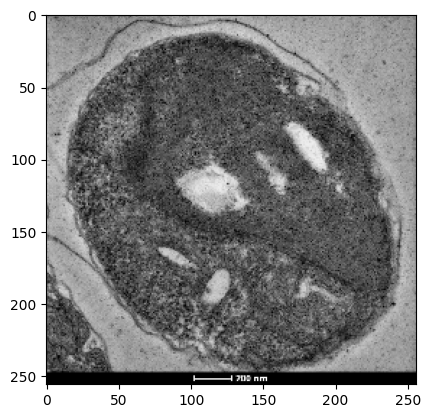

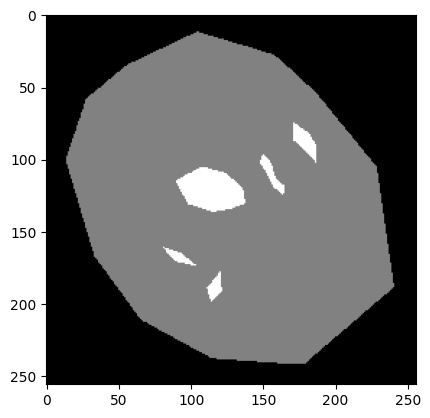

In [31]:
#Verify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.show()
plt.imshow(train_masks[0], cmap='gray')
plt.show()

1/1 [==============================] - 5s 5s/step


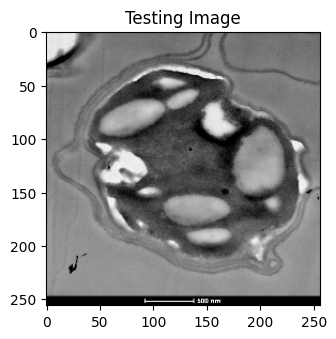

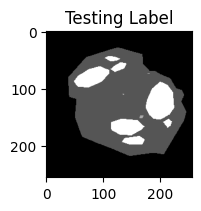

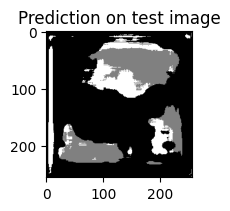

In [32]:
# Test some random images
import random
test_img_number = random.randint(0, len(X_test2))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input2(test_img_input)

test_pred1 = model2.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.show()
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.show()
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()